## Lab 3: Anomaly Detection 1

In this lab, you will be working with detecting anomalies in data. You will use basic Python libraries and the PyOD (https://pyod.readthedocs.io/en/latest/) library for detecting anomalies. Save your implementations with the name 'lab2_yourname.ipynb' and submit by the due date.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
pd.set_option("display.max_columns",100)
from pyod.utils.example import visualize
from pyod.utils.data import evaluate_print

## Data overview

This dataset contains information on variants of the French wine. The dataset contains information on physicochemical variables that were recorded on different wine samples.

There 6497 datapoints and twelve variables, namely: fixed_acidity, volatile_acidity, citric_acid, residual_sugar, chlorides, free_sulfur_dioxide, total_sulfur_dioxide, density, pH, sulphates, alcohol level and quality.


In [2]:
wine_data= pd.read_excel('wine_data.xls')
wine_data

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.99780,3.51,0.56,9.4,5
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.99680,3.20,0.68,9.8,5
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.99700,3.26,0.65,9.8,5
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.99800,3.16,0.58,9.8,6
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.99780,3.51,0.56,9.4,5
...,...,...,...,...,...,...,...,...,...,...,...,...
6492,6.2,0.21,0.29,1.6,0.039,24.0,92.0,0.99114,3.27,0.50,11.2,6
6493,6.6,0.32,0.36,8.0,0.047,57.0,168.0,0.99490,3.15,0.46,9.6,5
6494,6.5,0.24,0.19,1.2,0.041,30.0,111.0,0.99254,2.99,0.46,9.4,6
6495,5.5,0.29,0.30,1.1,0.022,20.0,110.0,0.98869,3.34,0.38,12.8,7


In [3]:
wine_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6497 entries, 0 to 6496
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   fixed acidity         6497 non-null   float64
 1   volatile acidity      6497 non-null   float64
 2   citric acid           6497 non-null   float64
 3   residual sugar        6497 non-null   float64
 4   chlorides             6497 non-null   float64
 5   free sulfur dioxide   6497 non-null   float64
 6   total sulfur dioxide  6497 non-null   float64
 7   density               6497 non-null   float64
 8   pH                    6497 non-null   float64
 9   sulphates             6497 non-null   float64
 10  alcohol               6497 non-null   float64
 11  quality               6497 non-null   int64  
dtypes: float64(11), int64(1)
memory usage: 609.2 KB


Lets engineer a new feature 'score' that assigns values to the wine samples based on the quality.

In [4]:
#New feature
wine_data['score'] = [1 if x >= 5 else 0 for x in wine_data['quality']]


In [5]:
#For simplicity, we will now filter the dataset to a few features
wine_filtered=wine_data[['fixed acidity','volatile acidity', 'score']]

<div class='alert alert-block alert-warning' style="font-weight:bolder">
 
 ### Data visualization as a tool for anomaly detection

</div>

The simplest way to detect any anomalies or outliers in your dataset is to plot the data to identify any outlier patterns. 
In the example below, we implement a boxplot on feature: fixed acidity and a histogram on feature: volatile acidity to check for outliers.

{'whiskers': [<matplotlib.lines.Line2D at 0x7f0ba479e1d0>,
 'caps': [<matplotlib.lines.Line2D at 0x7f0ba4a47c10>,
 'boxes': [<matplotlib.lines.Line2D at 0x7f0ba476e190>],
 'medians': [<matplotlib.lines.Line2D at 0x7f0ba47ad250>],
 'fliers': [<matplotlib.lines.Line2D at 0x7f0ba47adc50>],
 'means': []}

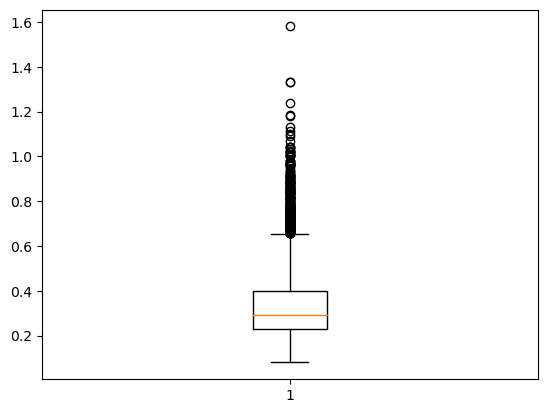

In [6]:
plt.boxplot(wine_filtered['volatile acidity'])

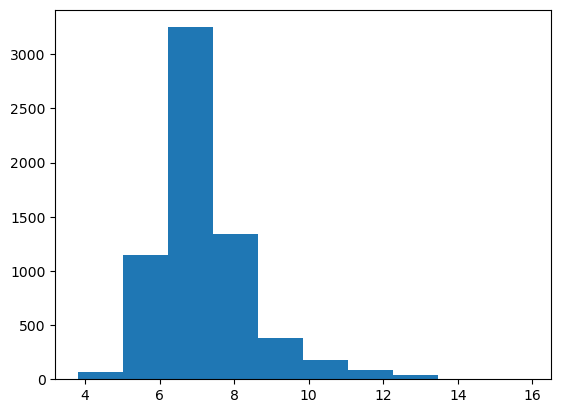

In [7]:
plt.hist(wine_filtered['fixed acidity'])
hist, bin_edges=np.histogram(wine_filtered['fixed acidity'].to_numpy(), density=False, bins=2)

<div class='alert alert-block alert-warning' style="font-weight:bolder">
 
 ### PyOD for anomaly detection

</div>


## Data Preparation


In [8]:
#we will use the 'score' as the labels and assign 'fixed acidity' and 'volatile acidity' as the features
labels=wine_filtered['score']
data=wine_filtered[['fixed acidity','volatile acidity']]

In [9]:
#we will use the standardizer from the PyOD library
from pyod.utils.utility import standardizer
data_std=standardizer(data)

In [10]:
#split percentage
split = int(0.7 * len(data))

train_data = data_std[:split]
test_data= data_std[split:]
train_labels= labels[:split]
test_labels=labels[split:]

In [11]:
print(len(train_labels))
x = 0
for i in train_labels:
    x += i
print(x)
#print(sum([1 for i in test_data if i == 1]))

4547
4353


<div class='alert alert-block alert-warning' style="font-weight:bolder">
 
 ### Multivariate Methods

</div>

## HBOS

The idea behind HBOS is to construct a histogram of the data for each dimension and calculate a score for how likely it is for a datapoint to fall within the histogram bins for each dimension. 

It is important to note that HBOS from PyOD is sensitive to the number of bins selected for the histograms.In the example below, we implement HBOS on our data with the number of bins set to 3 and observe the results.


On Training Data:
HBOS ROC:0.3953, precision @ rank n:0.9343

On Test Data:
HBOS ROC:0.3606, precision @ rank n:0.7949


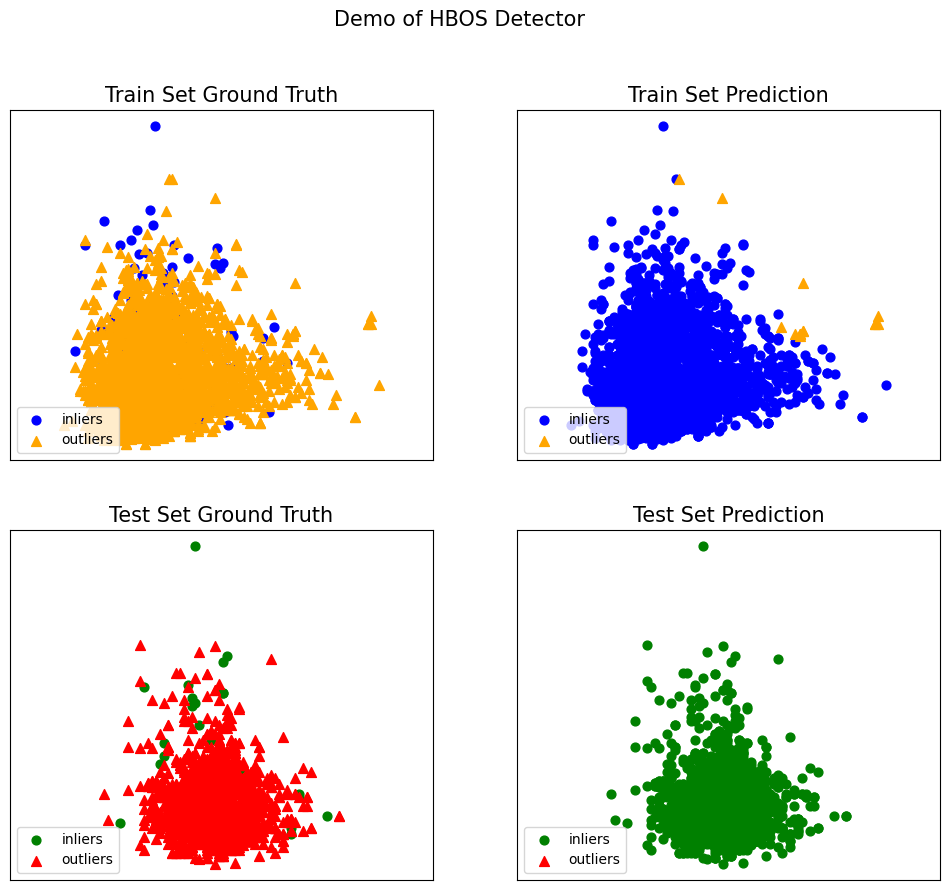

In [12]:
from pyod.models.hbos import HBOS

clf_hb=HBOS(n_bins=3, contamination=0.0367)
clf_hb.fit(train_data)

# get the prediction labels and outlier scores of the training data
train_pred_hb = clf_hb.labels_  # binary labels (0: inliers, 1: outliers)
train_scores_hb = clf_hb.decision_scores_  # raw outlier scores

# get the prediction on the test data
test_pred_hb = clf_hb.predict(test_data)  # outlier labels (0 or 1)
test_scores_hb = clf_hb.decision_function(test_data)  # outlier scores



# evaluate and print the results
print("\nOn Training Data:")
evaluate_print('HBOS', train_labels, train_scores_hb)
print("\nOn Test Data:")
evaluate_print('HBOS', test_labels, test_scores_hb)

visualize('HBOS', train_data, train_labels, test_data, test_labels, train_pred_hb, test_pred_hb, show_figure=True, save_figure=False)


<div class='alert alert-block alert-success' style="font-weight:bolder">

### Task 1

### Experiment with different values for the number of bins to see if you can increase the ROC score >= 0.75. 


</div>

In [13]:
#Please implement Task 1 here

import sklearn.metrics as metrics

score = []
for i in range(10):
    print(i+3, end=": ")
    clf_hb=HBOS(n_bins=i+3, contamination=0.0367)
    clf_hb.fit(train_data)
    
    # get the prediction labels and outlier scores of the training data
    train_pred_hb = clf_hb.labels_  # binary labels (0: inliers, 1: outliers)    
    train_scores_hb = clf_hb.decision_scores_  # raw outlier scores
    
    # get the prediction on the test data
    test_pred_hb = clf_hb.predict(test_data)  # outlier labels (0 or 1)
    test_scores_hb = clf_hb.decision_function(test_data)  # outlier scores

    score.append(metrics.roc_auc_score(test_labels, test_scores_hb))
    
    evaluate_print('HBOS', test_labels, test_scores_hb)


best_bins = score.index(max(score)) + 3
print("\n best score is found using bins =", best_bins)

3: HBOS ROC:0.3606, precision @ rank n:0.7949
4: HBOS ROC:0.4099, precision @ rank n:0.9737
5: HBOS ROC:0.3885, precision @ rank n:0.968
6: HBOS ROC:0.3612, precision @ rank n:0.9599
7: HBOS ROC:0.3723, precision @ rank n:0.9624
8: HBOS ROC:0.3843, precision @ rank n:0.9713
9: HBOS ROC:0.3833, precision @ rank n:0.9727
10: HBOS ROC:0.3925, precision @ rank n:0.9729
11: HBOS ROC:0.3501, precision @ rank n:0.9705
12: HBOS ROC:0.3737, precision @ rank n:0.9717

 best score is found using bins = 4


In [20]:
print(test_labels)

4547    1
4548    1
4549    1
4550    1
4551    1
       ..
6492    1
6493    1
6494    1
6495    1
6496    1
Name: score, Length: 1950, dtype: int64


### The ROC score is the highest when bins are equal to 4

<div class='alert alert-block alert-warning' style="font-weight:bolder">
 
 ### Neighbourhood-based Methods

</div>

Neighbourhood based methods try to detect various types of multivariate outliers by considering neighbourhoods of datapoints.

## KNN

<div class='alert alert-block alert-success' style="font-weight:bolder">

### Task 2

### Implement KNN with the pyod library. Use the Euclidean distance as the metric, and the average distance of the neighbours. Experiment with different values for n_neighbours. 

### Hint: https://pyod.readthedocs.io/en/latest/pyod.models.html#module-pyod.models.knn



</div>

In [14]:
#Please implement Task 2 here

from pyod.models.knn import KNN

score = []

for i in range(10):
    clf_knn = KNN(n_neighbors=i+1)
    clf_knn.fit(train_data)
    
    train_pred_knn = clf_knn.labels_  # binary labels (0: inliers, 1: outliers)
    train_scores_knn = clf_knn.decision_scores_  # raw outlier scores
    
    
    test_pred_knn = clf_knn.predict(test_data)  # outlier labels (0 or 1)
    test_scores_knn = clf_knn.decision_function(test_data)  # outlier scores

    print(i+1, end=": ")
    evaluate_print('KNN', test_labels, test_scores_knn)

    score.append(metrics.roc_auc_score(test_labels, test_scores_knn))

best_k = score.index(max(score)) + 1
print("\n best score is found using k =", best_k)


1: KNN ROC:0.4126, precision @ rank n:0.9494
2: KNN ROC:0.4109, precision @ rank n:0.9589
3: KNN ROC:0.3485, precision @ rank n:0.9578
4: KNN ROC:0.3297, precision @ rank n:0.962
5: KNN ROC:0.3418, precision @ rank n:0.9656
6: KNN ROC:0.3597, precision @ rank n:0.9682
7: KNN ROC:0.3683, precision @ rank n:0.9707
8: KNN ROC:0.3799, precision @ rank n:0.972
9: KNN ROC:0.3894, precision @ rank n:0.973
10: KNN ROC:0.3842, precision @ rank n:0.9731

 best score is found using k = 1


### The ROC score is the highest when n_neighbours are equal to 1

## LOF or COF

<div class='alert alert-block alert-success' style="font-weight:bolder">

### Task 3

### Take a look at the scatterplot of the dataset with our two feature fixed acidity and volatile acidity. Determine whether we should use LOF or COF on the dataset and implement it. Give a reason for your choice?


### Hint: Use functions from the PyOD library



</div>

<img src="images/scatter.png" alt="Alternative text" />

1: COF ROC:0.4126, precision @ rank n:0.9494
2: COF ROC:0.4109, precision @ rank n:0.9589
3: COF ROC:0.3485, precision @ rank n:0.9578
4: COF ROC:0.3297, precision @ rank n:0.962
5: COF ROC:0.3418, precision @ rank n:0.9656
6: COF ROC:0.3597, precision @ rank n:0.9682
7: COF ROC:0.3683, precision @ rank n:0.9707
8: COF ROC:0.3799, precision @ rank n:0.972
9: COF ROC:0.3894, precision @ rank n:0.973
10: COF ROC:0.3842, precision @ rank n:0.9731
11: COF ROC:0.3728, precision @ rank n:0.9738
12: COF ROC:0.3813, precision @ rank n:0.9742
13: COF ROC:0.3701, precision @ rank n:0.9744
14: COF ROC:0.3702, precision @ rank n:0.9736
15: COF ROC:0.3649, precision @ rank n:0.9717
16: COF ROC:0.3638, precision @ rank n:0.9722
17: COF ROC:0.3609, precision @ rank n:0.9723
18: COF ROC:0.3664, precision @ rank n:0.9705
19: COF ROC:0.3713, precision @ rank n:0.9709

 best score is found using n_neighbors = 1
1: COF ROC:0.4126, precision @ rank n:0.9494


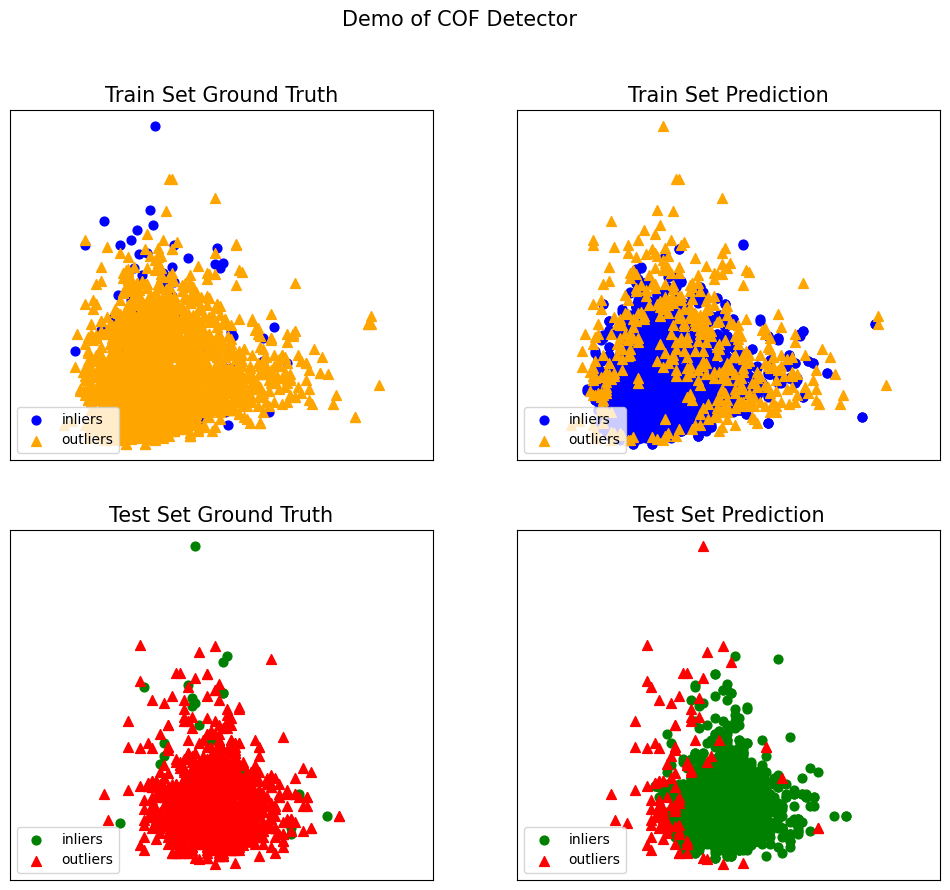

In [15]:
#Please implement Task 3 here

from pyod.models.cof import COF

def cof(neighbors):
    clf_cof = KNN(n_neighbors=neighbors)
    clf_cof.fit(train_data)
    
    train_pred_cof = clf_cof.labels_  # binary labels (0: inliers, 1: outliers)
    train_scores_cof = clf_cof.decision_scores_  # raw outlier scores
    
    
    test_pred_cof = clf_cof.predict(test_data)  # outlier labels (0 or 1)
    test_scores_cof = clf_cof.decision_function(test_data)  # outlier scores
    
    print(neighbors, end=": ")
    evaluate_print('COF', test_labels, test_scores_cof)
    
    return (metrics.roc_auc_score(test_labels, test_scores_knn), train_pred_cof, test_pred_cof)



score = []

for i in range(1, 20):
    score.append(cof(i)[0])

best_n = score.index(max(score)) + 1
print("\n best score is found using n_neighbors =", best_n)

best_cof = cof(best_n)

visualize('COF', train_data, train_labels, test_data, test_labels, best_cof[1], best_cof[2], show_figure=True, save_figure=False)


### I choose COF over LOF because it can distinguish isolated outliers from outliers in low-density areas.

<div class='alert alert-block alert-warning' style="font-weight:bolder">
 
 ### One-class classification based Methods

</div>

One-class classification based methods detect anomalies by finding a region of space where the majority of data samples reside with the highest density.

## One-class SVM

<div class='alert alert-block alert-success' style="font-weight:bolder">

### Task 4

### Implement OCSVM with a linear or non-linear kernel of your choice.

   
### Hint: Use functions from the PyOD library https://pyod.readthedocs.io/en/latest/_modules/pyod/models/ocsvm.html



</div>

OCSVM ROC:0.633, precision @ rank n:0.9789


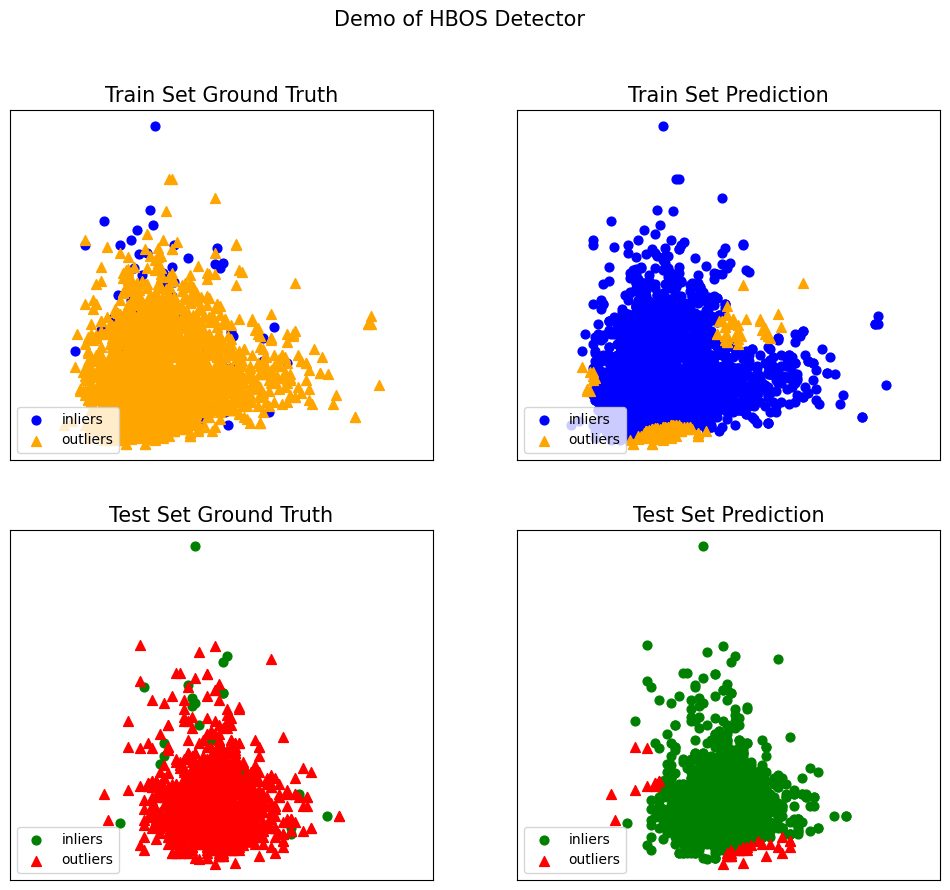

In [16]:
#Please implement Task 4 here

from pyod.models.ocsvm import OCSVM

clf_ocsvm = OCSVM(kernel='poly', contamination=0.0367)
clf_ocsvm.fit(train_data)

train_pred_ocsvm = clf_ocsvm.labels_  # binary labels (0: inliers, 1: outliers)
train_scores_ocsvm = clf_ocsvm.decision_scores_  # raw outlier scores


test_pred_ocsvm = clf_ocsvm.predict(test_data)  # outlier labels (0 or 1)
test_scores_ocsvm = clf_ocsvm.decision_function(test_data)  # outlier scores

evaluate_print('OCSVM', test_labels, test_scores_ocsvm)

visualize('HBOS', train_data, train_labels, test_data, test_labels, train_pred_ocsvm, test_pred_ocsvm, show_figure=True, save_figure=False)


<div class='alert alert-block alert-warning' style="font-weight:bolder">
 
 ### Clustering-based Methods

</div>

Clustering-based approaches assume that normal data belongs to large and dense clusters while, anomalies either do not belong to any of the clusters or form very small clusters.

<div class='alert alert-block alert-success' style="font-weight:bolder">

### Task 5

### Implement DBSCAN on the dataset. Experiment with 2 different values for epsilon and minpts. Report your results below. Which hyperparameter values give you better results??


Please note that we will use the sklearn version (https://scikit-learn.org/stable/modules/generated/sklearn.cluster.DBSCAN.html)

</div>

In [17]:
#Please implement Task 5 here

from sklearn.cluster import DBSCAN

score = []
for eps in [i/50 for i in range(1, 50)]:
    for ms in [3, 5]:
        
        clf_dbscan = DBSCAN(eps=eps, min_samples=ms)
        clf_dbscan.fit(train_data)
        
        dbscan_labels = clf_dbscan.labels_

        score.append((ms, eps, metrics.roc_auc_score(train_labels, dbscan_labels)))

best_dbscan = max(score, key=lambda x: x[1])

print("ms:", best_dbscan[0], "eps:", best_dbscan[1], "ROC:", best_dbscan[2])
    
    


ms: 3 eps: 0.98 ROC: 0.502689814584562


<div class='alert alert-block alert-success' style="font-weight:bolder">
    
### Task 6

### Compare the results from HBOS, One-class SVM, LOF or COF and KNN. Which one performed better? Can you think of any reasons why?.
    
</div>

### Write your answer to task 6 here.

### Results

| Method | ROC |
| --- | --- |
| HBOS | 0.4099 |
| KNN | 0.4126 |
| COF | 0.4126 |
| OCSVM | 0.633 |
| DBSCAN | 0.5026 |

The algorithm that worked best is one class SVM. One reason for it to be the best may be because it can cluster data with large differences in densities, and such is the case with this dataset.